In [80]:
import matplotlib.pyplot as plt
import numpy as np

#### Задача
Подумай пока над протоколом для вот такой задачи.
Есть 10 медальонов. Условно говоря, люди с медальонами шарахаются по лесу, время от времени сближаясь на расстояние, достаточное для прохождения сигнала.
Нужно сделать так, чтобы каждый медальон знал, сколько вокруг него других медальонов.

Если два медальона передают одновременно, то случается коллизия, и они друг друга глушат. То есть их никто не слышит.

Так что нужно придумать, как избежать коллизий. Состояние требуется обновлять раз в четыре секунды

#### Протокол передачи данных
**Отправка:** Пусть каждый медальон отправляет пакет со своим ID с частотой X Гц
**Сбор:** Пусть каждый медальон раз в четыре секунды переходит в состояние RX на $2\cdot\frac{1}{X}$

Корректность: Допустим, что каждый медальон выбирает в четырех секундах время для сбора случайно. Тогда вероятность того, что никакие два медальона пересекутся по времени передачи примерно равна $\prod\limits_{i = 2}^{10}{\left(1 - \frac{ 2\cdot\frac{1}{X}}{4}\cdot i \right)}$

Если никакие два медальона не пересекаются по времени приема, то во время приема одного медальона, остальные передают. Поскольку время RX = 2 * период отправки, то каждый медальон отправит хотя бы два раза сообщение принимающему медальону. Предлагается случайно менять время между двумя передачами, чтобы препятствовать синхронизации отдельных медальонов.

Посчитаем энергопотребление, как функцию от частоты
**MCU (4MHZ):**
1. wake up: 1mcS
2. 1mcA sleep current, 4MhZ = 1mA

**CC1101:**
1. wake up: 240mcs from sleep to tx/rx 8.4mA for intermediate consumption
2. 200 nA sleep mode, RX - 15mA, TX - 30mA
3. TX_time = 300mcS

Посчитаем потребление за 4с при скорости отправки 250 kBaud пакета размером 20байт:
#### Время на пробуждение
240mcs
#### Время в TX
0.64ms на отправку
#### Время в RX
$\frac{1}{X}s$


In [81]:
LOCKET_CNT = 30

SUPER_CYCLE_TIME = 4 # seconds
WAKE_UP_TIME = 240 * 10 ** -6
MCU_CONSUMPTION = 1 # mA
WAKE_UP_CONSUMPTION = 8.4 # mA
TX_TIME = 2 * 10 ** -3
TX_CONSUMPTION = 20
RX_CONSUMPTION = 20


def consumption(x):
    wake_up_time = WAKE_UP_TIME * (10 ** -6) * (x + 1)
    in_tx_time = TX_TIME * x
    in_rx_time = 2 / x
    sleep_time = (SUPER_CYCLE_TIME - in_tx_time - in_rx_time)
    # mAs
    consumption_cc1101 = \
        wake_up_time * WAKE_UP_CONSUMPTION + \
        in_tx_time * TX_CONSUMPTION + \
        in_rx_time * RX_CONSUMPTION
    return consumption_cc1101 + SUPER_CYCLE_TIME

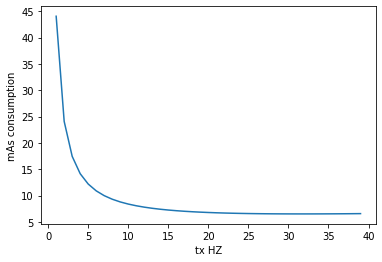

In [82]:
maxHz = SUPER_CYCLE_TIME / (WAKE_UP_TIME + TX_TIME)
# print(maxHz)
X = [i for i in range(1, int(40))]
Y = [consumption(x) for x in X]

plt.plot(X, Y)
plt.xlabel('tx HZ')
plt.ylabel('mAs consumption')
plt.show()

In [94]:
C = consumption(10) / 3600 # mAh per supercycle

In [95]:
700 / C * SUPER_CYCLE_TIME / 3600 / 24 # days work from 2 AAA battery (700mAh)

13.888888852222221

$L = {l_i | i \in 1..LOCKET CNT}$

Ниже мы рассмотрим один период RX медальона $l_1$ длиной $\frac{1}{X}s$. Посчитаем вероятность того, что он корректно примет сигнал от всех медальонов ${l_i | i \in 2..LOCKET CNT}$, которые могут быть на протяжении $\frac{1}{X}s$ в состоянии RX и/или TX. Медальон входит в RX после $TX_i$ и до $TX_{i+1}$. $time([TX_i, TX_{i+1}])=\frac{1}{X}s$

Будем рассматривать только временной отрезок $[TX_i, TX_{i+1}]$. Рассмотрим вероятность того, что медальону $l_2$ удасться

В этот отрезок каждый медальон в случайный момент времени пытается отправить сигнал.

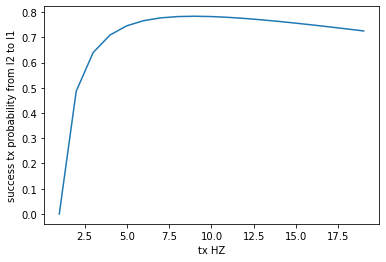

In [93]:
def success_probability(x):
    period = SUPER_CYCLE_TIME / x
    free_time = period - TX_TIME # free space for others. TX_TIME - tx time of l_2
    p = np.power(free_time / period, LOCKET_CNT - 2) # all other lockets 3..LOCKET_CNT
    p_of_no_rx_collision = (x - 1) / x # у второго медальона 4x отправок. Одна из которых будет испорчена его RX-ом. Вероятность того, что это наша отправка
    # не будет испорчена RX-ом равна (4x - 1) / 4x
    # print(p_of_no_rx_collision)
    return p * p_of_no_rx_collision

X = [i for i in range(1, int(20))]
PY = [success_probability(x) for x in X]

plt.plot(X, PY)
plt.xlabel('tx HZ')
plt.ylabel('success tx probability from l2 to l1')
plt.show()